In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Just for in this notebook
import sys
sys.path.append('../assignment1/to_hand_in/')
import some_routines as sr

# 1. Normally distributed pseudo-random numbers

#### a) Write a RNG that returns a float $\in$ [0,1]. At minimum, use some combination of MWC and XOR-shift. Plot the numbers against each other. Also plot the value for the first 1000 numbers vs the index of the number. Finally have your code generate a million random numbers and plot the result of binning these in 20 bins 0.05 wide.

In [2]:
seed = 19231923
print (f"User seed is set to {seed}")

User seed is set to 19231923


In [3]:
class RandomGenerator(object):
    """
    Random generator should be an object because it maintains
    internal state between calls.
    """
    def __init__(self, seed):
        # make sure the everyhing is an unsigned 64 bit integer
        dtyp = np.uint64
        # the seed for the LGC
        self.X1 = dtyp(seed)
        # the seed for the XORshift
        self.X2 = dtyp(seed)
        # the seed for the MWC, has to be smaller than 2**32
        self.X3 = dtyp(seed)
        if self.X3 >= 2**32:
            raise ValueError("Please provide a seed smaller than 2**32")
        
        self.max_value = dtyp(2**64 - 1)
        
        # LCG values from Numerical Recipies
        self.a = dtyp(1664525)
        self.c = dtyp(1013904223)
        self.m = dtyp(2**32)
        
        # 64 bit XOR shift values from Numerical Recipes
        self.a1, self.a2, self.a3 = dtyp(21), dtyp(35), dtyp(4)
        
        # MWC values from Numerical Recipes
        self.a2 = dtyp(4294957665)
        self.maxx = dtyp(2**32-1)
        self.shift = dtyp(32)
        
    def lincongen(self, X):    
        return (self.a*X+self.c) % self.m

    def XORshift64(self, X):
        if X == 0:
            raise ValueError("Seed cannot be zero")
        X = X ^ (X >> self.a1)
        X = X ^ (X << self.a2)
        X = X ^ (X >> self.a3)
        
        return X
    
    def MWC(self, X):
        X = self.a2*(X & self.maxx) + (X >> self.shift)
        # Use as a random number only lowest 32 bits
        # But in a bitmix, we can use all 64 bits.
        return X
    
    def get_randomnumber(self):
        """
        Combine LCG and XORshift to produce random float 
        between 0 and 1
        """
        self.X1 = self.lincongen(self.X1)
        self.X2 = self.XORshift64(self.X2)
        self.X3 = self.MWC(self.X3)
        
        # output is XOR of these numbers
        
        return ((self.X1^self.X3)^self.X2)/self.max_value
    
        

In [4]:
RNGESUS = RandomGenerator(seed=seed)

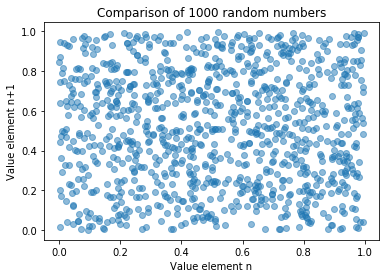

In [5]:
# Generate 1000 random numbers. Plot comparison
all_randnum = []
for i in range(1000):
    all_randnum.append(RNGESUS.get_randomnumber())

plt.plot(all_randnum,np.roll(all_randnum,1),'o',alpha=0.5)
plt.title(f'Comparison of {len(all_randnum)} random numbers')
plt.xlabel('Value element n')
plt.ylabel('Value element n+1')
plt.savefig('./plots/q1a1.png')
plt.show()
plt.close()

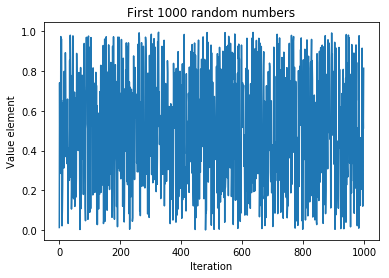

In [6]:
plt.plot(all_randnum)
plt.title(f'First {len(all_randnum)} random numbers')
plt.ylabel('Value element')
plt.xlabel('Iteration')
plt.savefig('./plots/q1a2.png')
plt.show()
plt.close()

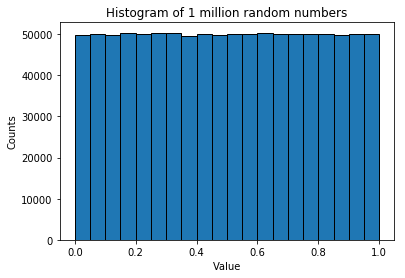

In [7]:
# Now generate 1 million random numbers. Plot histogram
all_randnum = []
for i in range(int(1e6)):
    all_randnum.append(RNGESUS.get_randomnumber())
all_randnum = np.array(all_randnum)
    
plt.hist(all_randnum,bins=sr.linspace(0,1,21),edgecolor='black')
plt.title(f'Histogram of 1 million random numbers')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.savefig('./plots/q1a3.png')
plt.show()
plt.close()

#### b. Now use the Box-Muller method to generate 1000 normally distributed random numbers.

In [8]:
def BoxMuller(randnums):
    """
    Given an input of random numbers drawn from Unif(0,1)
    return the same amount of random numbers drawn from Gaussian(0,1)
    """
    z1, z2 = randnums[:len(randnums)//2], randnums[len(randnums)//2:]
    a = np.sqrt(-2*np.log(z1))
    x1 = a*np.cos(2*np.pi*z2)
    x2 = a*np.sin(2*np.pi*z2)
    
    randnums2 = np.concatenate([x1,x2])
    
    return randnums2

def GaussianTransform(x,mu,sigma):
    """
    Takes x's drawn from a standard normal distribution and maps them 
    to arbitrary x ~ G(mu,sigma)
    """
    x *= sigma
    x += mu
    return x

def GaussianPdf(x,mean,sigma):
    """return the PDF of a Gaussian"""
    variance = sigma**2
    return 1/(np.sqrt(2*np.pi*variance)) * np.exp(-0.5*(x-mean)**2/variance)


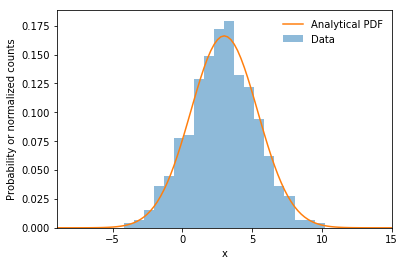

In [9]:
# We can use the first 1000 random numbers we have generated
randgauss = BoxMuller(all_randnum[:1000])
mu, sigma = 3, 2.4
randgauss = GaussianTransform(randgauss,mu,sigma)
# 20 equal width bins
hbins = sr.linspace(mu-3*sigma, mu+3*sigma,21)
nperbin, _, _ = plt.hist(randgauss,bins=hbins,label='data')
plt.close() # We could also set density is true, but since I am unsure
    # whether this is allowed, we shall normalize it manually.
bin_centers = (hbins[:-1] + hbins[1:])/2
binwidths = (hbins[1:] - hbins[:-1])
# Divide each bin by its width
# And divide by the total count to normalize
nperbin /= binwidths*np.sum(nperbin)

# Normalized histogram
plt.bar(bin_centers,nperbin,binwidths,label='Data',alpha=0.5)
# Analytical pdf
xs = sr.linspace(mu-5*sigma,mu+5*sigma,101)
plt.plot(xs, GaussianPdf(xs,mu,sigma),label='Analytical PDF',c='C1')

plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Probability or normalized counts')
plt.xlim(mu-5*sigma,mu+5*sigma)
plt.savefig('./plots/q1b1.png')
plt.show()
# plt.close()

#### c. Write a code that can do the KS-test on your function to determine whether it is consistent with a normal dist. For this, use $\mu=0$ and $\sigma=1$. Make a plot of the probability that your Gaussian random number generator is consistent with Gaussian distributed random numbers. Start with 10 random numbers and use in the plot a spacing of 0.1 dex until you have calculated it for $10^5$ random numbers on the x-axis. Compare your algorithm with the KS test from scipy by making another plot with the result from your KS-test and the KS-test from scipy.

The CDF of the standard normal distribution is given by
\begin{equation}
\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-t^2/2} dt
\end{equation}

This can be written as 
\begin{equation}
\Phi(x) = \frac{1}{2} \left( 1+\mathrm{erf}\left(\frac{x}{\sqrt{2}} \right) \right)
\end{equation}

Where erf($x$) is called the error function. It is defined as 
\begin{equation}
\mathrm{erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^x e^{-t^2} dt
\end{equation}

We calculate this error function by means of Romberg integration.

In [41]:
def romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    order -- Amount of steps combining trapezoids, 
    		 final step will have 2**order intervals
    
    Returns 
    Value of the integral
    Error estimate
     
    The error estimate is given as the difference between last 2 orders
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = sr.linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = sr.linspace(lbound,ubound,2**i+1)
        # add new points to the integral (use slicing to alternate)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # column of Romberg table
        for i in range(j,order): # row of Romberg table
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j - 1)
    
    return all_S[order-1,order-1], (all_S[order-1,order-1]-all_S[order-1,order-2])

def GaussianCdf(x):
    """
    Calculate the Gaussian CDF at point(s) x    
    """
    
    # the error function is the integral of this erfarg
    # from 0 to x/sqrt(2), multiplied by 2/sqrt(pi)
    erfarg = lambda t: np.exp(-t**2)
    
    if type(x) == np.ndarray or type(x) == list:
        if type(x) == list: 
            x = np.array(x)
        all_cdf = []
        for xnow in range(x):
            cdf = 0.5*(1+2/np.sqrt(np.pi)*romberg(erfarg,0,xnow/np.sqrt(2)
                                              ,order=12)[0])
            all_cdf.append(cdf)
            
    else:
        cdf = 0.5*(1+2/np.sqrt(np.pi)*romberg(erfarg,0,x/np.sqrt(2)
                                              ,order=12)[0])
    return cdf

In [42]:
def KStest(nperbin, bins, CDF):
    """
    Given an array of binned observations of x drawn from some PDF,
    this function uses the KS test to test whether x 
    follows the null hypothesis CDF
    
    nperbin -- counts per bin 
    bins    -- bin edges 
    CDF     -- CDF of null hypothesis
    """
    


In [43]:
print (GaussianCdf(1))


0.8413447460685425
